In [1]:
#https://github.com/ZFTurbo/volumentations
import glob
import os
import skimage
import numpy as np
import matplotlib.pyplot as plt
import gc
import pandas as pd
#import albumentations as A
import random
from scipy.ndimage import zoom
from skimage.exposure import match_histograms
from skimage import filters, io, img_as_ubyte, img_as_float32
from skimage import data
from skimage import exposure
import h5py
from volumentations import *
from skimage.filters import threshold_otsu
from scipy.ndimage.morphology import binary_erosion, distance_transform_edt, binary_fill_holes, binary_dilation
from skimage.measure import label
from skimage.morphology import remove_small_objects
from scipy import ndimage as ndi
from vedo import *
import pyvista as pv
from skimage.morphology import skeletonize
from sklearn.metrics import precision_score, recall_score, f1_score

#results from rootine
#rootlength[pix]
#123723.442
#186607.196

C:\Users\richa\AppData\Local\Temp\ipykernel_19944\633489481.py:19: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import binary_erosion, distance_transform_edt, binary_fill_holes, binary_dilation
C:\Users\richa\AppData\Local\Temp\ipykernel_19944\633489481.py:19: DeprecationWarning: Please import `distance_transform_edt` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import binary_erosion, distance_transform_edt, binary_fill_holes, binary_dilation
C:\Users\richa\AppData\Local\Temp\ipykernel_19944\633489481.py:19: DeprecationWarning: Please import `binary_fill_holes` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morph

### Overview
From rootine v2:
<br>
The quantification of root length from X-ray CT data has to be preceded by a step of skeletonization which conducts a medial axis transform of the segmented root image. This results in an image where all roots are reduced to a 1 pixel wide object which makes the calculations of root length more reliable and faster. 
<br>
<br>
Essentially we make all the roots a one pixel line and then count the pixels .. this is how you get root length from 3D volume.
<br>
<br>
So here we will compare the amount of root length the 3D unet can recover (root1s and rootines approach to quanitify accuracy) but also the F1 accuracy and recall of 3D u net and rootine v2 (essentially how the match 1:1 in a 3D space)


In [2]:
rootine=skimage.io.imread("F:\\rootine_data\\07_full_root_system.tif")
rootine=rootine[1:]
rootine[rootine !=0 ] = 1
pot_mask=skimage.io.imread("F:\\rootine_data\\rootine_transfer_their_seg\\comparing\\rootine_full_images_length_match\\pot_crop_test.tif")
unet_im=skimage.io.imread("F:\\rootine_data\\rootine_transfer_their_seg\\comparing\\pred_tif\\rootine_test_predictions.h5.tif")

Text(0.5, 1.0, 'unet')

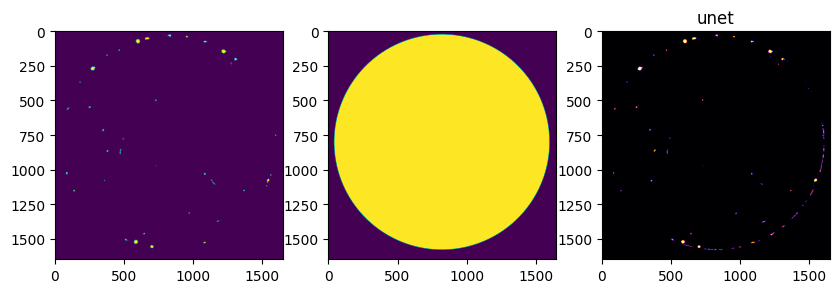

In [3]:
fig, ax = plt.subplots(1, 3, figsize=[10, 4])
ax[0].imshow(rootine[500])
plt.title ("rootine")
ax[1].imshow(pot_mask[500])
plt.title ("pot_mask")
ax[2].imshow(unet_im[500], cmap="inferno");
plt.title ("unet")

In [4]:
#Wrangle the unet output
thresh = threshold_otsu(unet_im[500:800])-75
unet_binary = (unet_im > thresh).astype('ubyte')
del unet_im
gc.collect()

65

In [5]:
thresh

38

In [6]:
#weights[weights !=0 ] = 1

In [7]:
diamond = ndi.generate_binary_structure(rank=3, connectivity=1)
iternation_n=2
pot_mask_erosion = ndi.binary_erosion(pot_mask, diamond, iterations=iternation_n)

In [8]:
unet_binary_pot  = unet_binary * pot_mask_erosion
skimage.io.imsave("F:\\rootine_data\\rootine_transfer_their_seg\\compare_out\\unet_clean.tif", unet_binary_pot, check_contrast=False)
del pot_mask_erosion
del pot_mask
del unet_binary
gc.collect()

0

In [9]:
# root_VOL = Volume(unet_binary_pot, spacing=((1),(1),(1)))
# root_ISO = root_VOL.isosurface(1)
# root_ISO.write("F:\\rootine_data\\rootine_transfer_their_seg\\compare_out\\3D_UNET.stl")

In [10]:
# root_VOL = Volume(rootine, spacing=((1),(1),(1)))
# root_ISO = root_VOL.isosurface(1)
# root_ISO.write("F:\\rootine_data\\rootine_transfer_their_seg\\compare_out\\rootine.stl")

In [11]:
#skeltonize rootine
rootine_skeleton = skeletonize(rootine)
data_rootine_skeleton = np.array(rootine_skeleton)
data_rootine_skeleton=data_rootine_skeleton.flatten()
data_rootine_skeleton=data_rootine_skeleton[data_rootine_skeleton != 0]

In [12]:
#skeltonize unet
unet_binary_pot_skeleton = skeletonize(unet_binary_pot)
data_unet = np.array(unet_binary_pot_skeleton)
data_unet=data_unet.flatten()
data_unet=data_unet[data_unet != 0]

In [13]:
print ("results from rootine v2 paper = 186607.196")
print ("python results from rootine v2 mask= "+ str(int(len(data_rootine_skeleton))))
print ("python results from 3Dunet= "+ str(int(len(data_unet))))
print ("the 3D unet is "+ str((int(len(data_unet)) - int(len(data_rootine_skeleton)))/int(len(data_rootine_skeleton)))+ "% off")
del rootine_skeleton
del unet_binary_pot_skeleton
gc.collect()

results from rootine v2 paper = 186607.196
python results from rootine v2 mask= 187613
python results from 3Dunet= 174874
the 3D unet is -0.06790041201835693% off


0

In [14]:
#memory crashes so just testing F1 on sub volume
unet_binary_pot=unet_binary_pot[300:800]
rootine=rootine[300:800]
flat_predictions = unet_binary_pot.flatten()
flat_ground_truths = rootine.flatten()
f1 = f1_score(flat_ground_truths, flat_predictions, average='binary')

precision = precision_score(flat_ground_truths, flat_predictions, average='binary')  # or 'micro', 'weighted', etc.
recall = recall_score(flat_ground_truths, flat_predictions, average='binary') 

qc_metrics = {'QC_test': ['precision', 'recall', 'f1'],
        'QC_result': [precision, recall, f1]}
qc_metrics = pd.DataFrame(qc_metrics)
qc_metrics.to_csv("F:\\rootine_data\\rootine_transfer_their_seg\\compare_out\\qc_metrics.csv") 

In [15]:
f1

0.7616213312279158